In [1]:
import numpy as np
import choix
import opt_fair
from scipy.optimize import minimize
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
from matplotlib import colors
import pandas as pd
import seaborn as sns

In [2]:
import pickle
with open("../data/FaceAgePC.pickle", 'rb') as handle:
    PC_faceage = pickle.load(handle)

In [3]:
with open("../data/FaceAgeDF1.pickle", 'rb') as handle:
    df_faceage = pickle.load(handle)

In [4]:
PC_faceage[4]

{(614, 1057),
 (1596, 6415),
 (2124, 3295),
 (2530, 3702),
 (2920, 3752),
 (4616, 1197),
 (5316, 4497),
 (5556, 3705),
 (7338, 6160),
 (8519, 3830),
 (8999, 2734),
 (9017, 5796)}

In [5]:
df_faceage

,full_path,score,gender
0,nm1442940_rm3965098752_1996-10-3_2006.jpg,10,0.0
1,nm4832920_rm1781768448_2003-8-28_2013.jpg,10,0.0
2,nm0652089_rm860657920_1992-3-10_2002.jpg,10,0.0
3,nm0004917_rm1493730304_1969-5-12_1979.jpg,10,0.0
4,nm1113550_rm1332711936_1996-4-14_2006.jpg,10,0.0
...,...,...,...
9145,475367_1941-08-03_2011.jpg,70,1.0
9146,304085_1919-07-07_1989.jpg,70,1.0
9147,nm0001627_rm4164078592_1927-2-20_1997.jpg,70,1.0
9148,nm0000024_rm1715129344_1904-4-14_1974.jpg,70,1.0


In [6]:
classes = df_faceage['gender']
FaceAge = opt_fair.Pairwise_with_rev(data = PC_faceage, penalty = 0, classes = classes)

In [7]:
all_pc_faceage  = opt_fair._pc_without_reviewers(PC_faceage)

In [8]:
size = len(df_faceage)

In [9]:
size

9150

In [235]:
%%time
A = opt_fair._matrix_of_comparisons(size,all_pc_faceage)
P = opt_fair._trans_prob(A)
rank_centrality_temp = np.log(opt_fair._stationary_dist(P))

CPU times: total: 25min 50s
Wall time: 16min 54s


In [236]:
stats.kendalltau(rank_centrality_temp,df_faceage['score'])

KendalltauResult(correlation=0.5577933783858906, pvalue=0.0)

In [54]:
crowd_labels = pd.read_csv('../data/crowd_labels.csv')
num_reviewers =  crowd_labels['performer'].nunique()

In [55]:
num_reviewers

4091

In [56]:
FaceAge

In [57]:
%%time
annot_bt_temp,annot_bias =  opt_fair._alternate_optim(size, num_reviewers, FaceAge, iters = 25)

CPU times: user 51min 23s, sys: 2min 34s, total: 53min 58s
Wall time: 10min 8s


In [58]:
stats.kendalltau(annot_bt_temp,df_faceage['score'])

SignificanceResult(statistic=0.5771630049961866, pvalue=0.0)

In [63]:
def crowd_alternate_optim(size, num_reviewers, pc_with_revs, iters = 101, tol = 1e-5, gtol = 1e-5):
    '''x0 is the estimated scores
       y0 is the estimated bias for each reviewer'''
    x0 = np.random.uniform(-1,1, size)
    y0 = np.ones(num_reviewers)*0.7
    bounds = [(0, 1)] * len(y0)


    for i in range(iters):

        
        
        # minimize with y fixed and update x
        res_x = minimize(lambda x: pc_with_revs.crowdbt_objective(x, y0), x0,tol = tol,  jac=lambda x: pc_with_revs.crowdbt_gradient_scores(x, y0), options={"gtol": gtol,'maxiter': 1})
        x0 = res_x.x
        
        
        # minimize with x fixed and update y
        res_y = minimize(lambda y: pc_with_revs.crowdbt_objective(x0, y), y0,tol = tol, jac=lambda y: pc_with_revs.crowdbt_gradient_revs(x0, y), bounds=bounds, options={"gtol": gtol,'maxiter': 1})
        y0 = res_y.x

        #if ((i) % 100 == 0):
            #print(f"Iteration {i}: x = {x0}, y = {y0}")
            #print(res_x.success)
            #print(res_y.success)

        if res_x.success and res_y.success:
            #print("Minimum found!")
            #print(f"Iteration {i}: x = {x0}, y = {y0}")
            #print(res_x.success)
            #print(res_y.success)
            break
    return x0,y0

In [64]:
%%time
crowd_bt_temp,crowd_bt_bias =  crowd_alternate_optim(size, num_reviewers, FaceAge, iters = 10)

CPU times: total: 40min 50s
Wall time: 33min 8s


In [61]:
stats.kendalltau(crowd_bt_temp,df_faceage['score'])

KendalltauResult(correlation=0.5769974240496533, pvalue=0.0)

In [24]:
import csv

# Saving annot_bt_temp as CSV
with open('annot_bt_temp.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['annot_bt_temp'])  # Write header
    writer.writerow(annot_bt_temp)  # Write data

# Saving annot_bias as CSV
with open('annot_bias.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['annot_bias'])  # Write header
    writer.writerow(annot_bias)  # Write data

In [59]:
import csv

# Reload annot_bt_temp from CSV
with open('annot_bt_temp.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)  # Read the header
    annot_bt_temp = np.array([float(row) for row in next(reader)])  # Read and convert the data to float

# Reload annot_bias from CSV
with open('annot_bias.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)  # Read the header
    annot_bias = np.array([float(row) for row in next(reader)])  # Read and convert the data to float


In [60]:
stats.kendalltau(annot_bt_temp,df_faceage['score'])

SignificanceResult(statistic=0.5771630049961866, pvalue=0.0)

In [61]:
print(np.mean(annot_bias))
print(np.std(annot_bias))

0.09054022973517496
0.9000565771687902


/Users/antonioferrara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/antonioferrara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


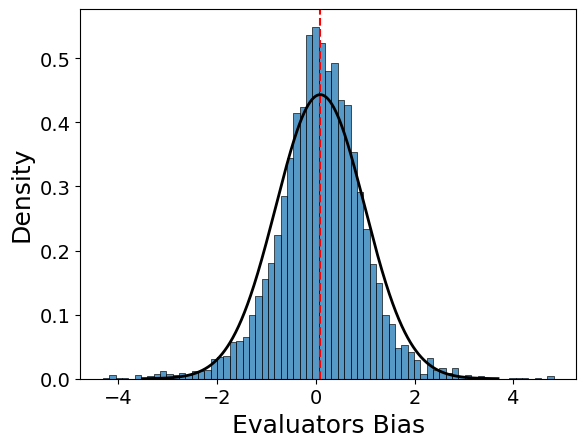

In [66]:
mean = np.mean(annot_bias)
std = np.std(annot_bias)
def normal(mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 5000)
    p = stats.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth=2)

data = annot_bias   
ax = sns.histplot(x=data, stat="density")
plt.axvline(annot_bias.mean(), color='red', linestyle='--')
normal(data.mean(), data.std())
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Evaluators Bias', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.savefig("../plots/dist_annot_bias.pdf", bbox_inches="tight")
plt.show()

In [67]:
annot_bias

array([-2.36434535e-01, -7.61969574e-01,  3.12973952e+00, ...,
        0.00000000e+00, -1.25001725e-03, -5.46236457e-01])

/Users/antonioferrara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/antonioferrara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/antonioferrara/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/antonioferrara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_

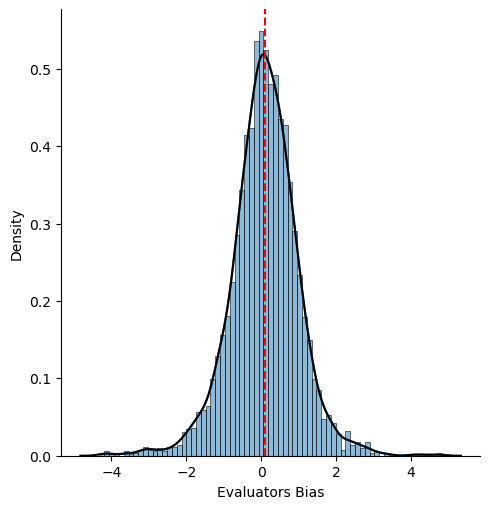

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.displot(annot_bias, kde=True, stat='density')
sns.kdeplot(annot_bias, color='black')
plt.axvline(annot_bias.mean(), color='red', linestyle='--')
plt.xlabel('Evaluators Bias')
plt.savefig("../plots/dist_annot_bias_kde.pdf", bbox_inches="tight")
plt.show()


In [69]:
all_pc_faceage[1][1].dtype

dtype('int64')

In [70]:
smallest_indices = sorted(range(len(estim)), key=lambda i: estim[i])[:100]
np.array(smallest_indices)

array([6, 4, 5, 0, 3, 8, 2, 9, 1, 7])

In [71]:
np.sum(np.array(smallest_indices)>9000)

0

In [72]:
df_faceage.tail(5)

,full_path,score,gender
9145,475367_1941-08-03_2011.jpg,70,1.0
9146,304085_1919-07-07_1989.jpg,70,1.0
9147,nm0001627_rm4164078592_1927-2-20_1997.jpg,70,1.0
9148,nm0000024_rm1715129344_1904-4-14_1974.jpg,70,1.0
9149,nm0000323_rm3114703104_1933-3-14_2003.jpg,70,1.0


In [73]:
# create empty dictionary to store the results
results_dict = {}

# load DataFrame into a NumPy array
arr = df_faceage.to_numpy()

# iterate over each item in the dictionary
for key, pairs in PC_faceage.items():
    
    
    # initialize counts for each combination of genders
    num_wrong_pairs = np.zeros((2, 2))
    num_correct_pairs = np.zeros((2, 2))

    # iterate over each pair in the list
    for pair in pairs:
        i,j = pair

        score1, gender1 = arr[i, [1, 2]]
        score2, gender2 = arr[j, [1, 2]]

        # update counts based on gender and score comparisons
        if gender1 == 0:
            if gender2 == 0:
                num_correct_pairs[0, 0] += (score1 > score2)
                num_wrong_pairs[0, 0] += (score1 < score2)
            else:
                num_correct_pairs[0, 1] += (score1 > score2)
                num_wrong_pairs[0, 1] += (score1 < score2)
        else:
            if gender2 == 0:
                num_correct_pairs[1, 0] += (score1 > score2)
                num_wrong_pairs[1, 0] += (score1 < score2)
            else:
                num_correct_pairs[1, 1] += (score1 > score2)
                num_wrong_pairs[1, 1] += (score1 < score2)

    # add results to dictionary
    results_dict[key] = {
        'num_wrong_pairs_0_0': num_wrong_pairs[0, 0],
        'num_wrong_pairs_0_1': num_wrong_pairs[0, 1],
        'num_wrong_pairs_1_0': num_wrong_pairs[1, 0],
        'num_wrong_pairs_1_1': num_wrong_pairs[1, 1],
        'num_correct_pairs_0_0': num_correct_pairs[0, 0],
        'num_correct_pairs_0_1': num_correct_pairs[0, 1],
        'num_correct_pairs_1_0': num_correct_pairs[1, 0],
        'num_correct_pairs_1_1': num_correct_pairs[1, 1]
    }

# create DataFrame from results dictionary
df_results = pd.DataFrame.from_dict(results_dict, orient='index')

# display results
print(df_results)


      num_wrong_pairs_0_0  num_wrong_pairs_0_1  num_wrong_pairs_1_0  \
0                     4.0                  6.0                  4.0   
1                     5.0                  2.0                  1.0   
2                     2.0                  0.0                  3.0   
3                     2.0                  1.0                  2.0   
4                     2.0                  1.0                  0.0   
...                   ...                  ...                  ...   
4086                  1.0                  0.0                  2.0   
4087                  0.0                  1.0                  0.0   
4088                  0.0                  0.0                  0.0   
4089                  0.0                  0.0                  1.0   
4090                  1.0                  1.0                  0.0   

      num_wrong_pairs_1_1  num_correct_pairs_0_0  num_correct_pairs_0_1  \
0                     5.0                   26.0                   27.0 

In [74]:
df_results['annot_bias'] = annot_bias
df0 = df_results[(df_results['num_wrong_pairs_1_0'] + df_results['num_correct_pairs_0_1']) > 5]
df1 = df_results[(df_results['num_wrong_pairs_0_1'] + df_results['num_correct_pairs_1_0']) > 5]
df2 = df_results[(df_results['num_wrong_pairs_0_0'] + df_results['num_correct_pairs_0_0']) > 5]
df3 = df_results[(df_results['num_wrong_pairs_1_1'] + df_results['num_correct_pairs_1_1']) > 5]

/Users/antonioferrara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/antonioferrara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/antonioferrara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/antonioferrara/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

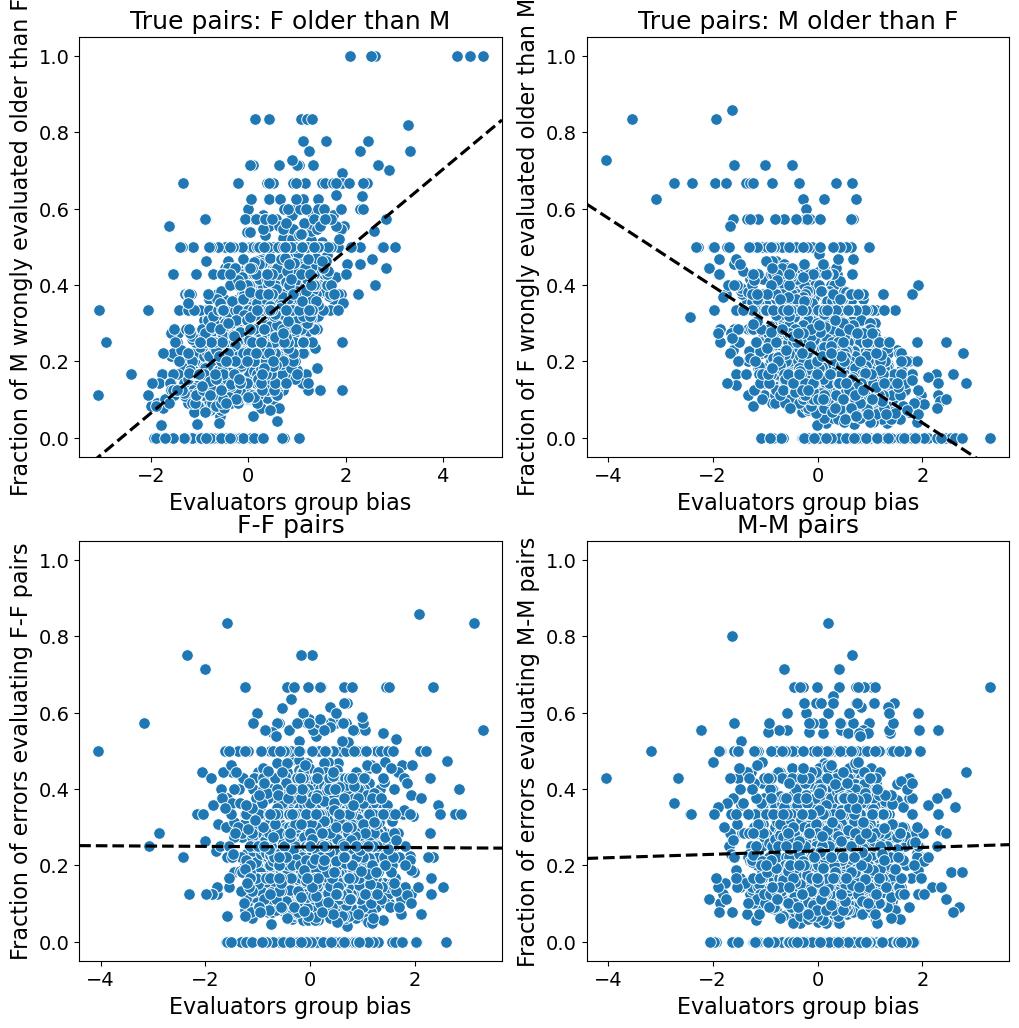

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 12))


plt.rc("axes", labelsize=16)  # Font size for the axis labels
plt.rc("xtick", labelsize=14)  # Font size for the x-axis tick labels
plt.rc("ytick", labelsize=14)  # Font size for the y-axis tick labels
plt.rc("axes", titlesize=18)  # Font size for the title

# Set the range for x-axis
#x_axis_range = (-5, 5)

# Set the range for y-axis
y_axis_range = (-0.05, 1.05)

sns.scatterplot(data=df0, x='annot_bias', y=df0['num_wrong_pairs_1_0'] / (df0['num_wrong_pairs_1_0'] + df0['num_correct_pairs_0_1']), s=70, ax=axs[0, 0])
sns.regplot(data=df0, x='annot_bias', y=df0['num_wrong_pairs_1_0'] / (df0['num_wrong_pairs_1_0'] + df0['num_correct_pairs_0_1']), ax=axs[0, 0], color='black', scatter=False, ci=None, line_kws={'linestyle': '--'}, truncate=False)

#axs[0, 0].set_xlim(x_axis_range)
axs[0, 0].set_ylim(y_axis_range)
axs[0, 0].set_xlabel('Evaluators group bias')
axs[0, 0].set_ylabel('Fraction of M wrongly evaluated older than F')
axs[0, 0].set_title('True pairs: F older than M')

sns.scatterplot(data=df1, x='annot_bias', y=df1['num_wrong_pairs_0_1'] / (df1['num_wrong_pairs_0_1'] + df1['num_correct_pairs_1_0']),s=70, ax=axs[0, 1])
sns.regplot(data=df1, x='annot_bias', y=df1['num_wrong_pairs_0_1'] / (df1['num_wrong_pairs_0_1'] + df1['num_correct_pairs_1_0']), ax=axs[0, 1], color='black', scatter=False, ci=None, line_kws={'linestyle': '--'}, truncate=False)

#axs[0, 1].set_xlim(x_axis_range)
axs[0, 1].set_ylim(y_axis_range)
axs[0, 1].set_xlabel('Evaluators group bias')
axs[0, 1].set_ylabel('Fraction of F wrongly evaluated older than M')
axs[0, 1].set_title('True pairs: M older than F')

sns.scatterplot(data=df2, x='annot_bias', y=df2['num_wrong_pairs_0_0'] / (df2['num_wrong_pairs_0_0'] + df2['num_correct_pairs_0_0']),s=70, ax=axs[1, 0])
sns.regplot(data=df2, x='annot_bias', y=df2['num_wrong_pairs_0_0'] / (df2['num_wrong_pairs_0_0'] + df2['num_correct_pairs_0_0']), ax=axs[1, 0], color='black', scatter=False, ci=None, line_kws={'linestyle': '--'}, truncate=False)

#axs[1, 0].set_xlim(x_axis_range)
axs[1, 0].set_ylim(y_axis_range)
axs[1, 0].set_xlabel('Evaluators group bias')
axs[1, 0].set_ylabel('Fraction of errors evaluating F-F pairs')
axs[1, 0].set_title('F-F pairs')

sns.scatterplot(data=df3, x='annot_bias', y=df3['num_wrong_pairs_1_1'] / (df3['num_wrong_pairs_1_1'] + df3['num_correct_pairs_1_1']),s=70, ax=axs[1, 1])
sns.regplot(data=df3, x='annot_bias', y=df3['num_wrong_pairs_1_1'] / (df3['num_wrong_pairs_1_1'] + df3['num_correct_pairs_1_1']), ax=axs[1, 1], color='black', scatter=False, ci=None, line_kws={'linestyle': '--'}, truncate=False)

#axs[1, 1].set_xlim(x_axis_range)
axs[1, 1].set_ylim(y_axis_range)
axs[1, 1].set_xlabel('Evaluators group bias')
axs[1, 1].set_ylabel('Fraction of errors evaluating M-M pairs')
axs[1, 1].set_title('M-M pairs')

plt.savefig("../plots/fpr_and_bias.pdf", bbox_inches="tight")
plt.show()
